In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kneed as kn
import plotly.graph_objects as go
import random

In [2]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

In [3]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


## Hierarchical clustering

### Agglomerative clustering

In [6]:
df = pd.read_csv('train_cleaned_v.2.csv')

In [7]:
del df['popularityIndex']  #non usare con nolog_unscaled
del df['originalTitle']
del df['rating']
del df['titleType']
del df['countryOfOrigin']
del df['genres']
del df['isAdult']
del df['isRatable']
del df['canHaveEpisodes']

In [8]:
del df['ratingCount']

In [9]:
df.head()

,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalCredits,AwNmExWins,numRegions,ratingMean,ReviewsTotal
0,0.801370,0.070175,0.000000,0.411369,0.084924,0.350105,0.000000,0.000000,0.777778,0.092661
1,0.712329,0.049123,0.000000,0.058580,0.084924,0.000000,0.000000,0.000000,0.555556,0.000000
2,0.780822,0.161404,0.000000,0.158191,0.084924,0.368770,0.000000,0.000000,0.555556,0.092661
3,0.979452,0.092982,0.000000,0.082893,0.384160,0.489104,0.000000,0.000000,0.555556,0.000000
4,0.972603,0.140351,0.139085,0.665190,0.717011,0.464013,0.143559,0.788491,0.777778,0.818761


In [10]:
df.describe()

,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalCredits,AwNmExWins,numRegions,ratingMean,ReviewsTotal
count,15925.000000,15925.000000,15925.00000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000,15925.000000
mean,0.782299,0.104119,0.02742,0.196306,0.161657,0.415279,0.032908,0.133626,0.685805,0.121934
std,0.177556,0.068448,0.08865,0.149170,0.146447,0.155723,0.102543,0.200470,0.153072,0.163077
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.684932,0.050877,0.00000,0.082893,0.084924,0.320806,0.000000,0.000000,0.555556,0.000000
50%,0.815068,0.092982,0.00000,0.158191,0.134602,0.422010,0.000000,0.000000,0.666667,0.092661
75%,0.924658,0.157895,0.00000,0.275891,0.238413,0.512704,0.000000,0.257722,0.777778,0.185323
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
'''
USARE SOLO CON TRAIN NO LOG/LOG UNSCALED
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
'''

'\nUSARE SOLO CON TRAIN NO LOG/LOG UNSCALED\nscaler = MinMaxScaler()\ndf = scaler.fit_transform(df)\n'

In [ ]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
#IL DISTANCE TRESHOLD DECIDE L'ALTEZZA A CUI TAGLIARE IL DENDOGRAMMA, RESTITUISCE IL NUMERO DI CLUSTER LA SILHOUETTE RELATIVA
#ALL'ALTEZZA DEL TAGLIO.
#IL NUMERO DELLA DISTANCE TRESHOLD PUò ESSERE VISTO SULLA VERTICALE Y DEL GRAFICO.
distance_threshold=0.92
average_link = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, metric='euclidean', linkage='average')
average_link = average_link.fit(df)

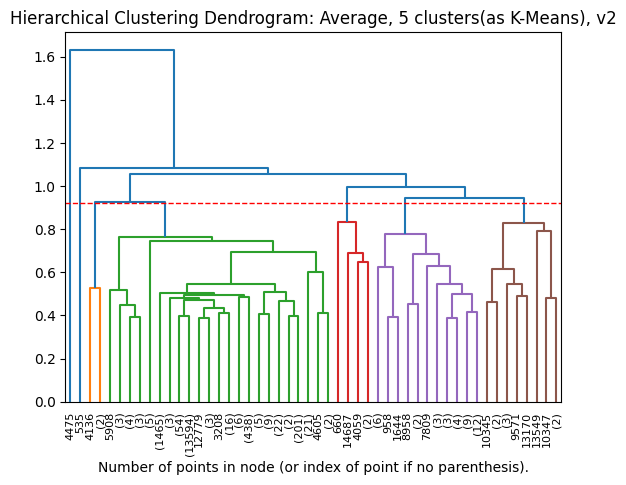

labels {np.int64(0): np.int64(5), np.int64(1): np.int64(12), np.int64(2): np.int64(43), np.int64(3): np.int64(1), np.int64(4): np.int64(15860), np.int64(5): np.int64(1), np.int64(6): np.int64(3)}
silhouette 0.6347762577432641


In [ ]:
plt.title("Hierarchical Clustering Dendrogram: Average, 5 clusters(as K-Means), v2")
plot_dendrogram(average_link, truncate_mode="lastp", p=50, color_threshold=distance_threshold)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=distance_threshold, color='red', linestyle='--', linewidth=1, label='Distance Treshold')
plt.show()

hist, bins = np.histogram(average_link.labels_, bins=range(0, len(set(average_link.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df, average_link.labels_))

Average, 5 clusters (as K-Means), v2: 
- silhouette = 0.4030227597168208
- labels {np.int64(0): np.int64(1046), np.int64(1): np.int64(14861), np.int64(2): np.int64(1), np.int64(3): np.int64(13), np.int64(4): np.int64(4)}



In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
distance_threshold=1.62
complete_link = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, metric='euclidean', linkage='complete')
complete_link = complete_link.fit(df)

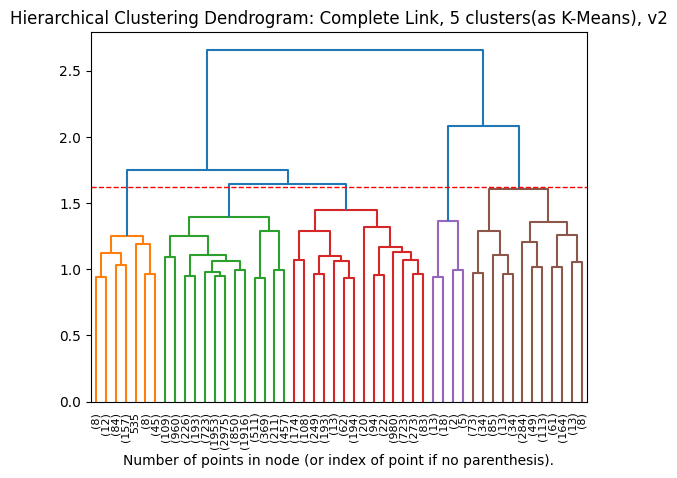

labels {np.int64(0): np.int64(931), np.int64(1): np.int64(3188), np.int64(2): np.int64(38), np.int64(3): np.int64(315), np.int64(4): np.int64(11453)}
silhouette 0.1582323846826559


In [ ]:
plt.title("Hierarchical Clustering Dendrogram: Complete Link, 5 clusters(as K-Means), v2")
plot_dendrogram(complete_link, truncate_mode="lastp", p=50, color_threshold=distance_threshold)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=distance_threshold, color='red', linestyle='--', linewidth=1, label='Distance Treshold')
plt.show()

hist, bins = np.histogram(complete_link.labels_, bins=range(0, len(set(complete_link.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df, complete_link.labels_))

Complete Link, 5 clusters(as K-Means), v2:
- silhouette 0.1582323846826559
- labels {np.int64(0): np.int64(931), np.int64(1): np.int64(3188), np.int64(2): np.int64(38), np.int64(3): np.int64(315), np.int64(4): np.int64(11453)}


In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
distance_threshold=17
ward_link = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, metric='euclidean', linkage='ward')
ward_link = ward_link.fit(df)

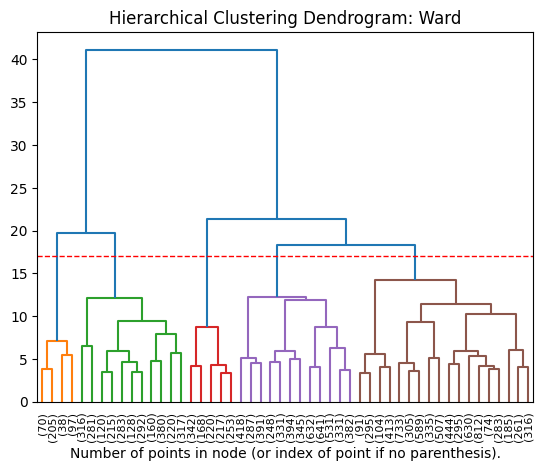

labels {np.int64(0): np.int64(6672), np.int64(1): np.int64(4931), np.int64(2): np.int64(1200), np.int64(3): np.int64(410), np.int64(4): np.int64(2712)}
silhouette 0.10993893890129477


In [ ]:
plt.title("Hierarchical Clustering Dendrogram: Ward, 5 clusters(as K-Means), v2")
plot_dendrogram(ward_link, truncate_mode="lastp", p=50, color_threshold=18)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=distance_threshold, color='red', linestyle='--', linewidth=1, label='Distance Treshold')
plt.show()

hist, bins = np.histogram(ward_link.labels_, bins=range(0, len(set(ward_link.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(df, ward_link.labels_))

Ward, 5 clusters(as K-Means), v2:
- silhouette 0.10993893890129477
- labels {np.int64(0): np.int64(6672), np.int64(1): np.int64(4931), np.int64(2): np.int64(1200), np.int64(3): np.int64(410), np.int64(4): np.int64(2712)}
